In [82]:
import pandas as pd
from bokeh.io import output_file, show, output_notebook, reset_output
from bokeh.plotting import figure

import networkx as nx
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx
from bokeh.layouts import gridplot
from scipy.stats import chi2_contingency


from src.graph import Graph, GraphBuilder
from src.utils import write_single_csv

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
reset_output()
output_notebook()

Loading BokehJS ...

In [71]:
def graph_from_args(args) -> Graph:
    return GraphBuilder() \
        .with_num_nodes(args["num_nodes"]) \
        .with_edge_density(args["edge_density"]) \
        .with_discrete_node_ratio(args["discrete_node_ratio"]) \
        .with_discrete_signal_to_noise_ratio(args["discrete_signal_to_noise_ratio"]) \
        .with_min_discrete_value_classes(args["min_discrete_value_classes"]) \
        .with_max_discrete_value_classes(args["max_discrete_value_classes"]) \
        .with_continuous_noise_std(args["continuous_noise_std"]) \
        .with_continuous_beta_mean(args["continuous_beta_mean"]) \
        .with_continuous_beta_std(args["continuous_beta_std"]) \
        .build()

args = {}
args["num_nodes"] = 6
args["num_samples"] = 10000
args["edge_density"] = 0.5
args["discrete_node_ratio"] = 1.0
args["discrete_signal_to_noise_ratio"] = 0.6
args["min_discrete_value_classes"] = 10
args["max_discrete_value_classes"] = 15
args["continuous_noise_std"] = 1.0
args["continuous_beta_mean"] = 1.0
args["continuous_beta_std"] = 1.0
args["num_processess"] = 1

graph_from_args(args)
G = graph_from_args(args)
dfs = G.sample(num_observations=args["num_samples"], num_processes=args["num_processess"])
df = pd.concat(dfs, copy=False)
df = df.reindex(sorted(df.columns), axis=1)

ground_truth = G.to_networkx_graph()
df.head()

,0,1,2,3,4,5
0,11,7,8,12,6,6
1,9,11,4,10,8,8
2,4,2,6,12,6,9
3,3,2,1,6,5,5
4,12,3,7,0,3,3


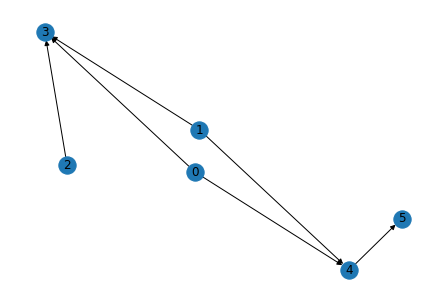

In [72]:
nx.draw_spring(ground_truth, with_labels = True)

In [73]:
plots = []
for column in df.columns:
    discrete_values = df[column].unique()
    counts = list(df[column].value_counts())

    p = figure(plot_height=250, title=f"Node: {column}",
               toolbar_location=None, tools="")

    p.vbar(x=discrete_values, top=counts, width=0.9)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    plots.append(p)
    
# make a grid
grid = gridplot(plots, ncols=int(len(df.columns) / 2), plot_width=250, plot_height=250)

show(grid)

In [111]:
num_values = len(df.columns)
mask = np.ones([num_values, num_values])
nodes = df.columns

true_values = np.zeros([num_values, num_values])
for edge in ground_truth.edges:
    x = int(edge[0])
    y = int(edge[1])
    true_values[x][y] = 1
    true_values[y][x] = 1
    
p_values = []
for column_index, column in enumerate(nodes):
    row_p_values = []
    for row_index, row in enumerate(nodes):
        ct = pd.crosstab(df[column], df[row])
        #display(ct)
        stat, p_value, degrees_of_freedom, expected = chi2_contingency(ct)
        row_p_values.append(p_value)
        
        if column_index > row_index:
            mask[column_index, row_index] = False
        
    p_values.append(row_p_values)
    
p_values = np.array(p_values)

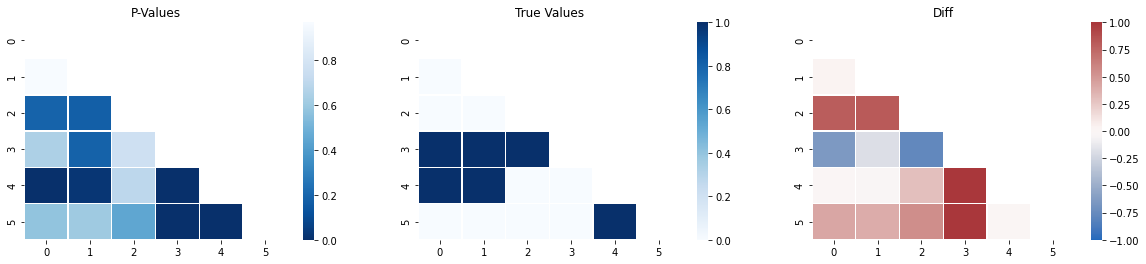

In [117]:
fig = plt.figure(figsize=(20,4))

fig.subplots_adjust()

ax = fig.add_subplot(1, 3, 1)
ax.title.set_text('P-Values')
sns.heatmap(
    p_values,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="Blues_r",
    ax=ax
)

ax = fig.add_subplot(1, 3, 2)
ax.title.set_text('True Values')
sns.heatmap(
    true_values,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="Blues",
    ax=ax,
)

ax = fig.add_subplot(1, 3, 3)
ax.title.set_text('Diff')

flip_bool = lambda t: not t
vfunc = np.vectorize(flip_bool)
flipped_true_values = vfunc(true_values)

hm_data =  flipped_true_values - p_values 
sns.heatmap(
    hm_data,
    xticklabels=df.columns,
    yticklabels=df.columns,
    mask=mask,
    linewidths=.5,
    cmap="vlag",
    vmin=-1, vmax=1
)
plt.show()

In [78]:
#blau --> hat ne edge vergessen
#weiß --> hat edge korrekt vorhergesagt
#red --> hat edge vorausgesagt, ist aber keine da

AttributeError: 'DataFrame' object has no attribute 'Principal'

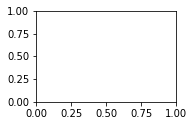

In [80]:
p_values

array([[0.00000000e+00, 9.68008605e-01, 1.92803924e-01, 6.47371702e-01,
        1.54806589e-03, 5.74899458e-01],
       [9.68008605e-01, 0.00000000e+00, 1.74166782e-01, 1.87001434e-01,
        2.60301508e-02, 6.05211048e-01],
       [1.92803924e-01, 1.74166782e-01, 0.00000000e+00, 7.65700747e-01,
        6.96275122e-01, 4.49607396e-01],
       [6.47371702e-01, 1.87001434e-01, 7.65700747e-01, 0.00000000e+00,
        2.01155668e-37, 1.21521110e-03],
       [1.54806589e-03, 2.60301508e-02, 6.96275122e-01, 2.01155668e-37,
        0.00000000e+00, 0.00000000e+00],
       [5.74899458e-01, 6.05211048e-01, 4.49607396e-01, 1.21521110e-03,
        0.00000000e+00, 0.00000000e+00]])